## Pre reqs

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService.save_account(
    token="vEDGkFb6wjY5VdjtscwhrTRVjmc7Kjk6tEQA_TQM2iPE", # Your token is confidential.
    # Do not share your key in public code.
    instance="crn:v1:bluemix:public:quantum-computing:us-east:a/ab694e4ed9b5499baefa745fb382d976:b7355021-fe98-4845-9674-9259222dee1b::",
    set_as_default=True, # Optionally set these as your default credentials.,
    overwrite=True # Overwrite existing credentials if any.
)

In [ ]:
service = QiskitRuntimeService()
backend = service.least_busy(simulator=False, operational=True)
 
# Convert to an ISA circuit and layout-mapped observables.
# pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
# isa_circuit = pm.run(qc)
 
# isa_circuit.draw("mpl", idle_wires=False)

## Prior Initialization Testing

In [9]:
import sys
import os

# Add the src folder (which is one level up and then into src/)
sys.path.append(os.path.abspath("../src"))

# Now import your function
from ansatz import create_improved_ansatz


In [14]:
ansatz, theta, phi, lambda_ = create_improved_ansatz(num_qubits=10, reps=5)

flat_params_list = theta + phi + lambda_

with open("../logs/pretrained_params.txt", "r") as f:
    params = f.read().strip().split()

with open("../logs/pretrain_fidelity_loss.txt", "r") as f:
    cost_history = f.read().strip().split()
    
params.pop(0)
params.pop(len(params) - 1)

cost_history.pop(0)
cost_history.pop(len(cost_history) - 1)

for i in range(len(params)):
    params[i] = float(params[i])
for i in range(len(cost_history)):
    cost_history[i] = float(cost_history[i])

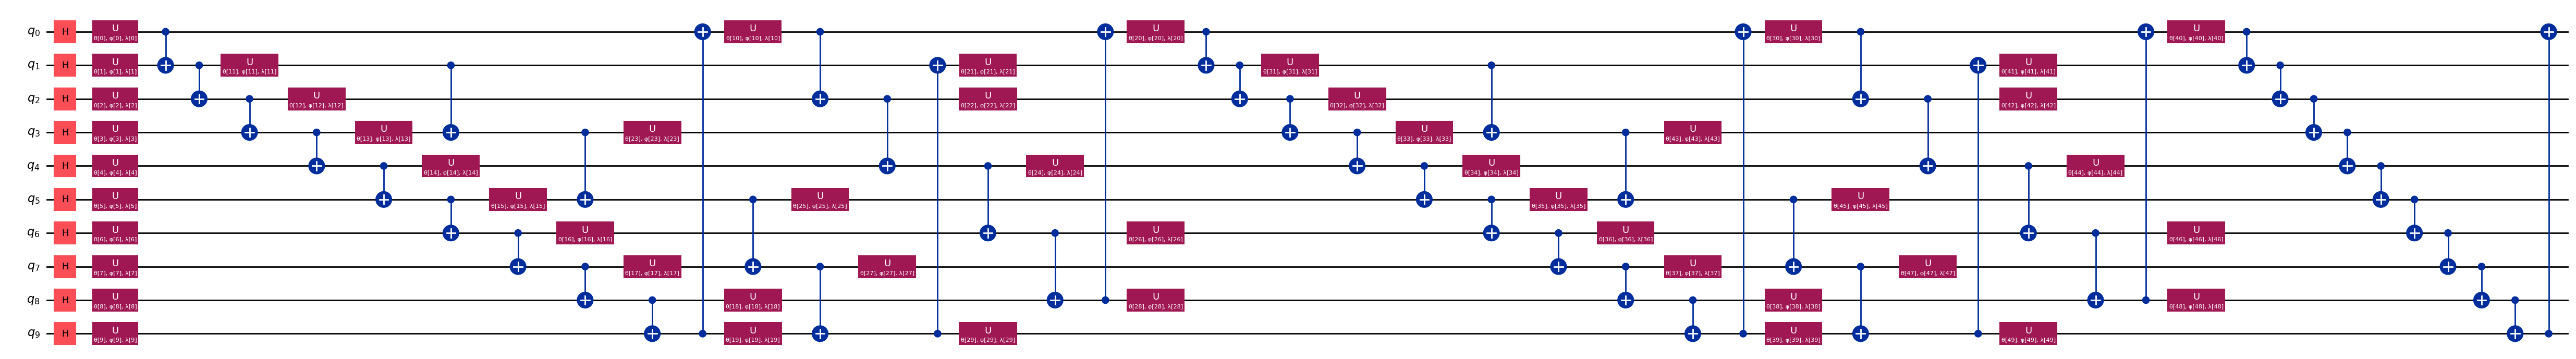

In [11]:
ansatz.draw('mpl', fold=-1)

In [ ]:
from qiskit_ibm_runtime import Sampler
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit

qc = QuantumCircuit(10, 10)
qc.compose(ansatz, inplace=True)
sample_qc = qc.copy()

# backend = AerSimulator(method='matrix_product_state')
    
sampler = Sampler(mode=backend)
estimator = 
binding = {p: v for p, v in zip(flat_params_list, params)}
qc.assign_parameters(binding, inplace=True)
transpiled_qc = transpile(qc, backend=backend)


# sv = Statevector.from_instruction(transpiled_qc)
# probs = sv.probabilities()

sample_qc.measure(range(10), range(10))
sample_transpiled_qc = transpile(sample_qc, backend=backend)
job = sampler.run([(sample_transpiled_qc, binding)], shots=2048*4)
    
result = job.result()._pub_results[0].data.c
counts = result.get_counts()

Number of circuit parameters: 150
Number of parameter values: 150
Unbound parameters in circuit: ParameterView([ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5]), ParameterVectorElement(θ[6]), ParameterVectorElement(θ[7]), ParameterVectorElement(θ[8]), ParameterVectorElement(θ[9]), ParameterVectorElement(θ[10]), ParameterVectorElement(θ[11]), ParameterVectorElement(θ[12]), ParameterVectorElement(θ[13]), ParameterVectorElement(θ[14]), ParameterVectorElement(θ[15]), ParameterVectorElement(θ[16]), ParameterVectorElement(θ[17]), ParameterVectorElement(θ[18]), ParameterVectorElement(θ[19]), ParameterVectorElement(θ[20]), ParameterVectorElement(θ[21]), ParameterVectorElement(θ[22]), ParameterVectorElement(θ[23]), ParameterVectorElement(θ[24]), ParameterVectorElement(θ[25]), ParameterVectorElement(θ[26]), ParameterVectorElement(θ[27]), ParameterVectorElement(θ[28]),

In [23]:
bitstring_probs = {
    format(i, f'0{10}b'): float(p)
    for i, p in enumerate(counts.values())
    if p > 1e-10  # filter negligible terms
}
len(bitstring_probs)

1022

In [24]:
print(counts)
print(type(counts))

{'1001111111': 3, '1010110011': 14, '1101101100': 10, '0010001101': 4, '1111011100': 17, '1111011110': 12, '0101100110': 7, '0000101100': 12, '1101101111': 2, '1011001110': 8, '0110011101': 14, '1010000111': 15, '0010000010': 6, '1010010010': 3, '1100111101': 3, '1110110111': 13, '1011101100': 6, '0001011010': 6, '1000011000': 10, '0100111000': 10, '0000001110': 7, '1111001010': 12, '1011010011': 4, '0101010111': 9, '0111111100': 11, '1001110000': 17, '1010011100': 5, '0111001111': 14, '1111011011': 12, '0111110000': 26, '1111101010': 15, '1001110011': 5, '0110111001': 13, '1101000001': 6, '1100110100': 7, '0110010010': 15, '0100101111': 6, '1000110000': 7, '1101011001': 6, '1110101111': 12, '0111111010': 13, '1001010010': 5, '1100111111': 11, '0010100110': 6, '1011000000': 10, '1001011000': 12, '1010110010': 10, '1001111010': 5, '1000010001': 9, '0100010110': 7, '0110100100': 11, '1010111010': 5, '1010011101': 12, '0110110110': 10, '0110010000': 16, '0000000100': 7, '1111010010': 24, 

In [25]:
sorted_counts = dict(sorted(counts.items(), key=lambda item: int(item[0], 2)))

In [26]:
def bitstrings_to_ints(bitstrings: list) -> list:
    """
    Convert a list of bitstrings into a list of integers.
    
    Args:
        bitstrings: A list of strings, each a bitstring.
        
    Returns:
        A list of integers corresponding to the bitstrings.
    """
    return [int(b, 2) for b in bitstrings]

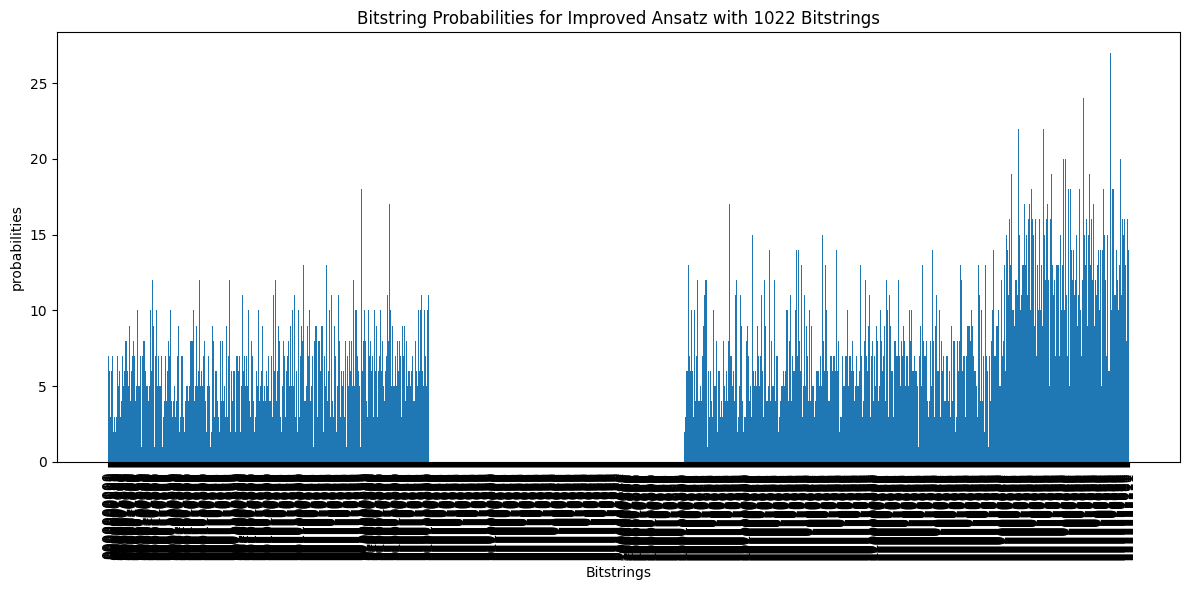

In [28]:
import matplotlib.pyplot as plt

top_len = 100

# Top counts manually
top_counts = dict(sorted(bitstring_probs.items(), key=lambda item: item[1], reverse=True)[:top_len])

# bitstrings = [str(int(key, 2)) for key in counts.keys()]
bitstrings = list(sorted_counts.keys())
values = list(sorted_counts.values())

plt.figure(figsize=(12, 6))
plt.bar(bitstrings, values)
# plt.title(f'Top {top_len} Measurement Counts')
plt.title(f'Bitstring Probabilities for Improved Ansatz with {len(bitstrings)} Bitstrings')
plt.xlabel('Bitstrings')
plt.ylabel('probabilities')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [29]:
import sys
import os

# Add the src folder (which is one level up and then into src/)
sys.path.append(os.path.abspath("../"))

# Now import your function
from ansatz import create_improved_ansatz

import config as config
# Print the configuration parameters
center_key = config.PRIOR_CENTER_KEY

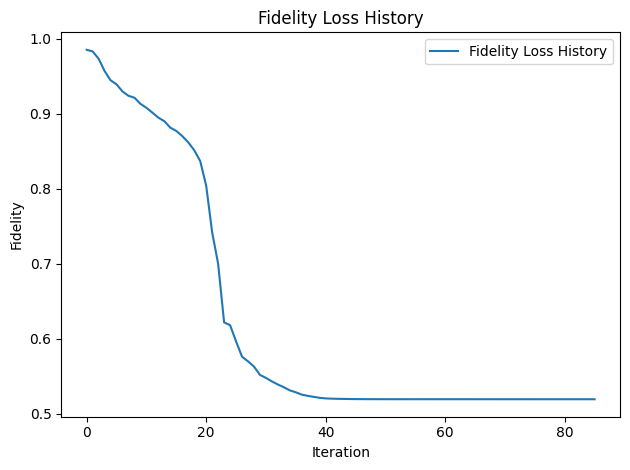

In [30]:
plt.plot(cost_history, label='Fidelity Loss History')
plt.title('Fidelity Loss History')
plt.xlabel('Iteration')
plt.ylabel('Fidelity')
plt.legend()
plt.tight_layout()
plt.show()

In [31]:
sum(values)

8192

In [32]:
most_frequent_bitstring = max(bitstring_probs, key=bitstring_probs.get)
print(f"Most frequent bitstring: {most_frequent_bitstring} with probability amplitude {bitstring_probs[most_frequent_bitstring]}")

Most frequent bitstring: 1010010100 with probability amplitude 27.0


In [83]:
# top_counts["0111000000"]

## Cost Function Plotting 

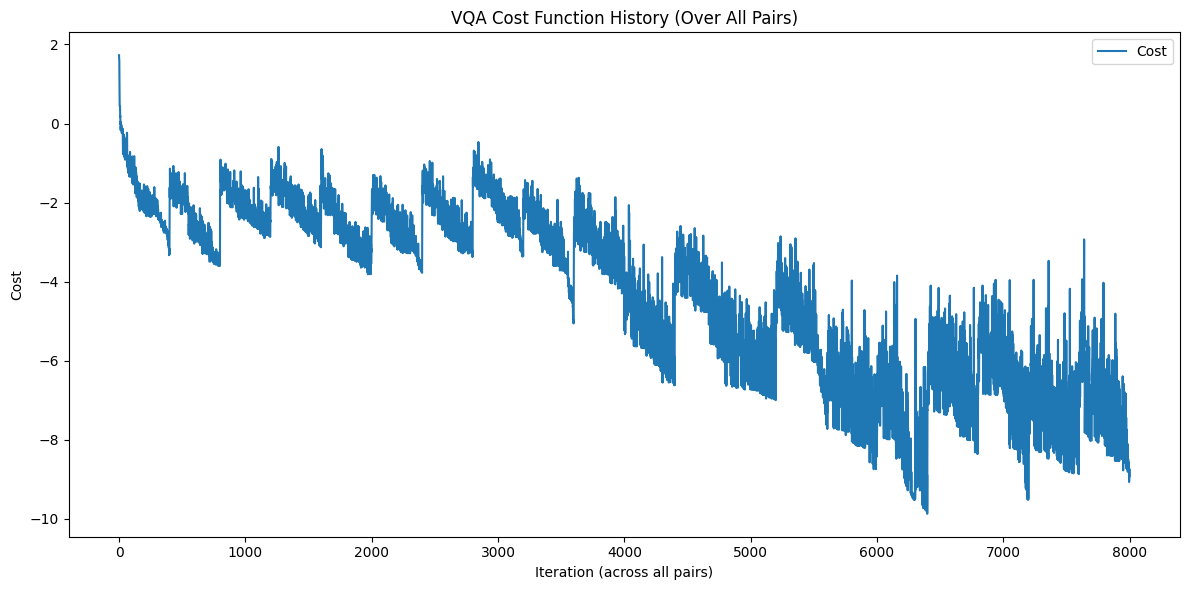

In [1]:
import json
import matplotlib.pyplot as plt

# Load the results
with open("../runtime_comparison_results.json", "r") as f:
    results = json.load(f)

# If your JSON is a list of results, get the first element
res_len = len(results)
cost_history_per_pair = results[res_len - 1]["cost_history_per_pair"]
all_costs = [cost for pair in cost_history_per_pair for cost in pair]


# Plot as a single continuous line
plt.figure(figsize=(12, 6))
plt.plot(all_costs, label='Cost')
plt.xlabel("Iteration (across all pairs)")
plt.ylabel("Cost")
plt.title("VQA Cost Function History (Over All Pairs)")
plt.legend()
plt.tight_layout()
plt.show()

True key is 0111010010
Most probable key is : 0111010010


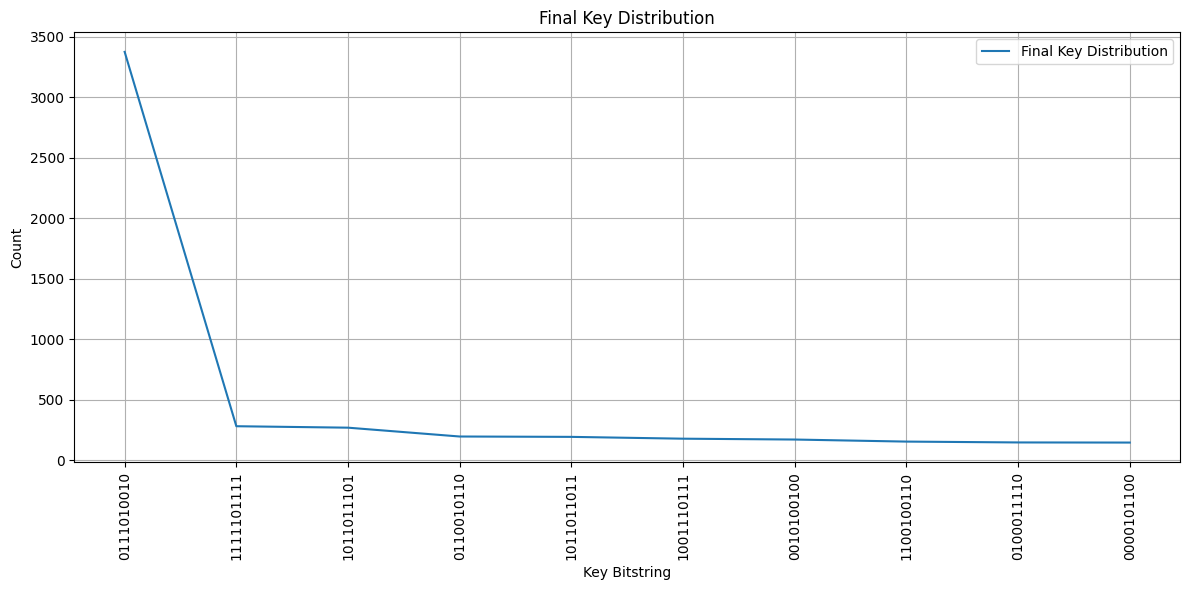

In [2]:
final_counts_array = results[res_len - 1]["top_10_bitstrings"]
final_counts = {kv[0] : kv[1] for kv in final_counts_array}
print(f"True key is {results[res_len - 1]["true_key"]}")
print(f"Most probable key is : {final_counts_array[0][0]}")
plt.figure(figsize=(12, 6))
plt.plot(final_counts.keys(), final_counts.values(), label='Final Key Distribution')
plt.xlabel("Key Bitstring")
plt.ylabel("Count")
plt.title("Final Key Distribution")
plt.legend()
plt.grid()
plt.xticks(rotation=90)
plt.margins()
plt.tight_layout()
plt.show()

# Extra tests

## Hamming distance

In [29]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt


def hamming_gaussian_prior(n_bits: int, center_key: np.ndarray, std_dev: float) -> np.ndarray:
    """
    Construct a normalized Gaussian prior over all 2^n_bits possible keys,
    where distance is measured by Hamming distance to center_key.

    Args:
        n_bits: Number of bits in the key (e.g., 10).
        center_key: A length-n_bits numpy array of 0s and 1s indicating the center of the prior.
        std_dev: Standard deviation for the Gaussian on Hamming distance.

    Returns:
        A length-(2^n_bits) numpy array of probabilities summing to 1.
    """
    # Enumerate all 2^n_bits keys as bit arrays
    all_keys = np.array([list(map(int, format(i, f"0{n_bits}b"))) for i in range(2**n_bits)])
    # Compute Hamming distance to center_key for each key
    hamming_dist = np.sum(all_keys != center_key, axis=1)
    # Evaluate Gaussian PDF at those distances (mean=0)
    probs = norm.pdf(hamming_dist, 0, std_dev)
    # Normalize into a probability distribution
    return probs / np.sum(probs)


def hamming_distance(str1: str, str2: str) -> int:
    """
    Compute the Hamming distance between two equal-length bitstrings.

    Args:
        str1: First bitstring (e.g., "1010010101").
        str2: Second bitstring of the same length.

    Returns:
        The number of positions at which the corresponding bits differ.
    """
    if len(str1) != len(str2):
        raise ValueError("Strings must be of equal length.")
    return sum(c1 != c2 for c1, c2 in zip(str1, str2))

## Cosine Distance

In [30]:
import numpy as np

def cosine_distance(x, y):
    """Cosine distance = 1 - cosine similarity"""
    dot = np.dot(x, y)
    norm_product = np.linalg.norm(x) * np.linalg.norm(y)
    if norm_product == 0:
        return 1.0  # define max distance if either is zero vector
    return 1 - (dot / norm_product)

def cosine_gaussian_prior(n_bits: int, center_key: np.ndarray, std_dev: float) -> np.ndarray:
    """
    Construct a Gaussian prior over 2^n_bits binary keys based on cosine distance.
    
    Args:
        n_bits: Number of bits per key.
        center_key: Binary array of length n_bits representing the center.
        std_dev: Standard deviation for the Gaussian kernel over cosine distance.
    
    Returns:
        Normalized prior (length 2^n_bits) as numpy array.
    """
    num_keys = 2**n_bits
    all_keys = np.array([list(map(int, format(i, f"0{n_bits}b"))) for i in range(num_keys)])
    
    # Compute cosine distances
    distances = np.array([cosine_distance(key, center_key) for key in all_keys])
    
    # Apply Gaussian kernel: exp(-0.5 * (distance / std_dev)^2)
    unnormalized = np.exp(-0.5 * (distances / std_dev)**2)
    prior = unnormalized / np.sum(unnormalized)
    
    return prior


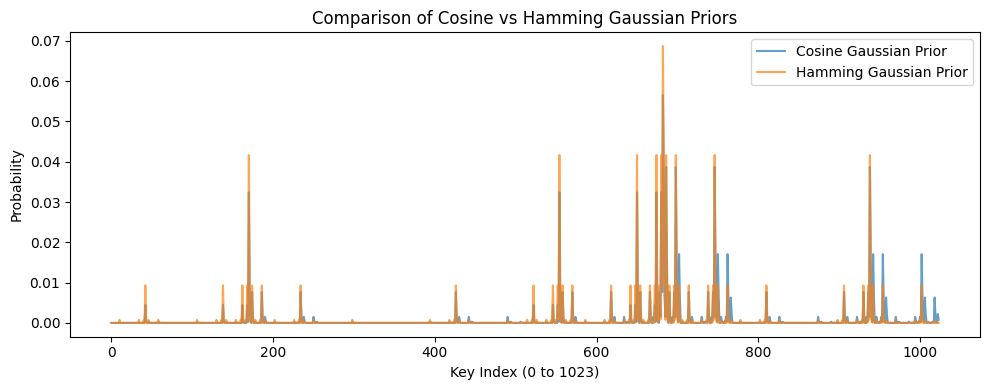

In [31]:
import matplotlib.pyplot as plt
import numpy as np

center = np.array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0])


prior_cosine = cosine_gaussian_prior(10, center, std_dev=0.1)
prior_hamming = hamming_gaussian_prior(10, center, std_dev=1.0)

x = np.arange(2**10)

plt.figure(figsize=(10, 4))
plt.plot(x, prior_cosine, label="Cosine Gaussian Prior", alpha=0.7)
plt.plot(x, prior_hamming, label="Hamming Gaussian Prior", alpha=0.7)
plt.xlabel("Key Index (0 to 1023)")
plt.ylabel("Probability")
plt.title("Comparison of Cosine vs Hamming Gaussian Priors")
plt.legend()
plt.tight_layout()
plt.show()



## Final param simulation 

In [52]:
import json

with open('../track_results.json', 'r') as f:
    data = json.load(f)
print(data)

[{'best_params_per_pair': [[3.51835037, 6.28312034, 4.64212622, 3.14053056, 0.000667678447, 1.77162846, -2.91352193e-05, 5.68493542, 3.86670806, 3.14176832, -0.00125386589, 7.28318544, 6.19165947, 1.56998357, 2.1348186, -0.000381542745, 1.54152507, 3.12705262, 3.14163092, 1.57082512, 4.71240827, -6.88637922e-05, 1.72402311, 3.13960787, 3.14277705, 4.71235372, 1.54943087, 3.14158301, 4.71235845, 0.000321872079, 4.71240164, 5.87200821e-05, -0.00208085761, 6.28314312, 6.2153645, 4.70903878, 0.000257871046, 0.164065948, 4.71290572, 3.14167318, -0.00120763956, 3.14141036, -0.00079969796, 6.2832087, 1.57081205, 4.7123563, 1.57085998, 3.14180592, 1.57086386, 1.57073438, 6.28316952, 4.3411433, 6.28348357, 5.55691358, 4.06398275, 4.71179673, 0.867898579, 0.0412135578, 0.0180968861, 2.31022357, 2.77370633, 1.22442309, 4.88731376, 2.57274473, 1.57079303, 3.94712684, 1.42580658, 4.67296772, 1.14252015, 6.28320723, 4.70678652, 2.53612616, 0.581468971, 5.27101349, 4.47401393, 4.69785028, 4.71242957,

In [54]:
params = data["best_params_per_pair"][0]

TypeError: list indices must be integers or slices, not str

In [ ]:
ansatz, theta, phi, lambda_ = create_improved_ansatz(num_qubits=10, reps=5)

flat_params_list = theta + phi + lambda_

In [ ]:
from qiskit_ibm_runtime import Sampler
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit

qc = QuantumCircuit(10, 10)
qc.compose(ansatz, inplace=True)
sample_qc = qc.copy()

backend = AerSimulator(method='matrix_product_state')
    
sampler = Sampler(mode=backend)
    
binding = {p: v for p, v in zip(flat_params_list, params)}
qc.assign_parameters(binding, inplace=True)
transpiled_qc = transpile(qc, backend=backend)


sv = Statevector.from_instruction(transpiled_qc)
probs = sv.probabilities()

sample_qc.measure(range(10), range(10))
sample_transpiled_qc = transpile(sample_qc, backend=backend)
job = sampler.run([(sample_transpiled_qc, binding)], shots=2048*4)
    
result = job.result()._pub_results[0].data.c
counts = result.get_counts()

In [ ]:
bitstring_probs = {
    format(i, f'0{10}b'): float(p)
    for i, p in enumerate(probs)
    if p > 1e-10  # filter negligible terms
}
bitstring_probs

{'0000000000': 0.001037946373469299,
 '0000000001': 0.0011658924103333872,
 '0000000010': 0.001091093133255034,
 '0000000011': 0.0007862639669439693,
 '0000000100': 0.0006117706506063717,
 '0000000101': 0.001414229839180173,
 '0000000110': 0.0013133113759808562,
 '0000000111': 0.000737174198783777,
 '0000001000': 0.0005925821874178151,
 '0000001001': 0.00023528584705787613,
 '0000001010': 0.00020942395783095214,
 '0000001011': 0.0005322964126198654,
 '0000001100': 0.00021365016876521785,
 '0000001101': 0.00014480354996469788,
 '0000001110': 0.00012739748648433566,
 '0000001111': 0.00013092454145041056,
 '0000010000': 3.0450539846181956e-05,
 '0000010001': 2.864350101073181e-05,
 '0000010010': 2.5407397649313074e-05,
 '0000010011': 2.7651986369472035e-05,
 '0000010100': 0.00011852962397717496,
 '0000010101': 0.00016865540792798398,
 '0000010110': 0.00016440920023215358,
 '0000010111': 0.00012218259138944065,
 '0000011000': 0.0023305832991918677,
 '0000011001': 0.0011696091983924048,
 '0

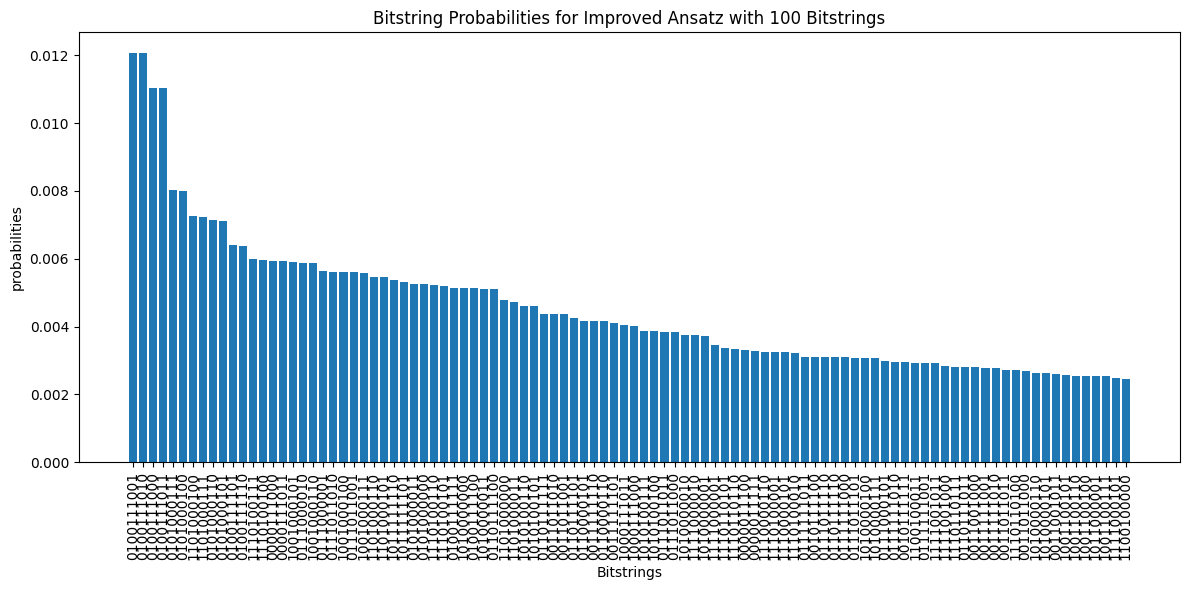

In [ ]:
import matplotlib.pyplot as plt

top_len = 100

# Top 20 counts manually
top_counts = dict(sorted(bitstring_probs.items(), key=lambda item: item[1], reverse=True)[:top_len])

# bitstrings = [str(int(key, 2)) for key in top_counts.keys()]
bitstrings = list(top_counts.keys())
values = list(top_counts.values())

plt.figure(figsize=(12, 6))
plt.bar(bitstrings, values)
# plt.title(f'Top {top_len} Measurement Counts')
plt.title(f'Bitstring Probabilities for Improved Ansatz with {len(bitstrings)} Bitstrings')
plt.xlabel('Bitstrings')
plt.ylabel('probabilities')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
top_counts["0111000010"]

0.005869727229079993

## Hamiltonian


In [96]:
plaintext = "00011101"
key = "0111010010"

from sdes import sdes_encrypt
ciphertext = sdes_encrypt(plaintext, key)

In [137]:
ciphertext = "00000000"

In [138]:
from hamiltonian import build_hamiltonian
ham = build_hamiltonian(ciphertext)

In [139]:
ciphertext

'00000000'

In [140]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, SparsePauliOp

qc = QuantumCircuit(10, 10)
qc.x([1, 4, 6, 7, 8])

sv = Statevector.from_instruction(qc)
probs = sv.probabilities_dict()

In [141]:
from collections import defaultdict

cipher_probs = defaultdict(float)

for k, v in probs.items():
    key = sdes_encrypt(plaintext, k)
    cipher_probs[key] += v

In [142]:
cipher_probs = {"00000000": 0.5, "11111111": 0.5}

In [143]:
def basis_state_expectation(cipher_text : str, hamiltonian : SparsePauliOp):
    sv = Statevector.from_label(cipher_text)
    exp = sv.expectation_value(hamiltonian)
    return exp    

In [144]:
expectation_value = (np.real(list([(basis_state_expectation(k, ham) * v) for k, v in cipher_probs.items()])))
expectation_value.sum()

np.float64(-24.0)

In [145]:
print(len(probs))
print(len(cipher_probs))

1
2


In [15]:
from qiskit_ibm_runtime import ibm_backend, EstimatorV2 as Estimator  
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit
def expectation_from_estimator(
    hamiltonian: SparsePauliOp,
    qc: QuantumCircuit,
    param_list,                # <-- Accept parameter list
    param_values,              # <-- Accept values
    backend: ibm_backend.IBMBackend = None,
    shots: int = 1024
) -> float:
    """
    Estimate the expectation value of a Hamiltonian using a parameterized quantum circuit.
    """
    if backend is None:
        from qiskit_aer import AerSimulator
        backend = AerSimulator()

    estimator = Estimator(mode=backend)
    binding = {p: v for p, v in zip(param_list, param_values)}
    job = estimator.run([(qc, hamiltonian, binding)])
    result = job.result()
    exp_value = float(result.values[0])
    print("Expectation value:", exp_value)

    return exp_value


In [17]:
import sys
import os

# Add the src folder (which is one level up and then into src/)
sys.path.append(os.path.abspath("../src"))

from ansatz import create_improved_ansatz
from qiskit_ibm_runtime import EstimatorV2 as Estimator, QiskitRuntimeService
from  qiskit import QuantumCircuit, transpile
from hamiltonian import build_hamiltonian
from sdes import sdes_encrypt

service = QiskitRuntimeService()
backend = service.least_busy()

plaintext = "01010101"
key = "1111010010"
ciphertext = sdes_encrypt(plaintext, key)

hamiltonian = build_hamiltonian(ciphertext)
ansatz, theta, phi, lambda_ = create_improved_ansatz(num_qubits=10, reps=5)
flat_params_list = theta + phi + lambda_
params = [0.1] * len(flat_params_list)
estimator = Estimator(mode=backend)
qc = QuantumCircuit(10, 10)
qc.compose(ansatz, inplace=True)

transpiled_qc = transpile(qc, backend=backend)
expectation_value = expectation_from_estimator(
    hamiltonian,
    qc,
    flat_params_list,   # <--- now passed explicitly
    params,
    backend=backend
)

print(f"Expectation value for ciphertext {ciphertext} is {expectation_value}")

ValueError: The number of qubits of the circuit (10) does not match the number of qubits of the ()-th observable (8).

## Ansatz

In [1]:
from ansatz import create_improved_ansatz, create_2local_ansatz, create_efficient_su2_ansatz

ansatz1, theta, phi, lambda_ = create_improved_ansatz(num_qubits=16, reps=3)
ansatz1.decompose().depth()


44

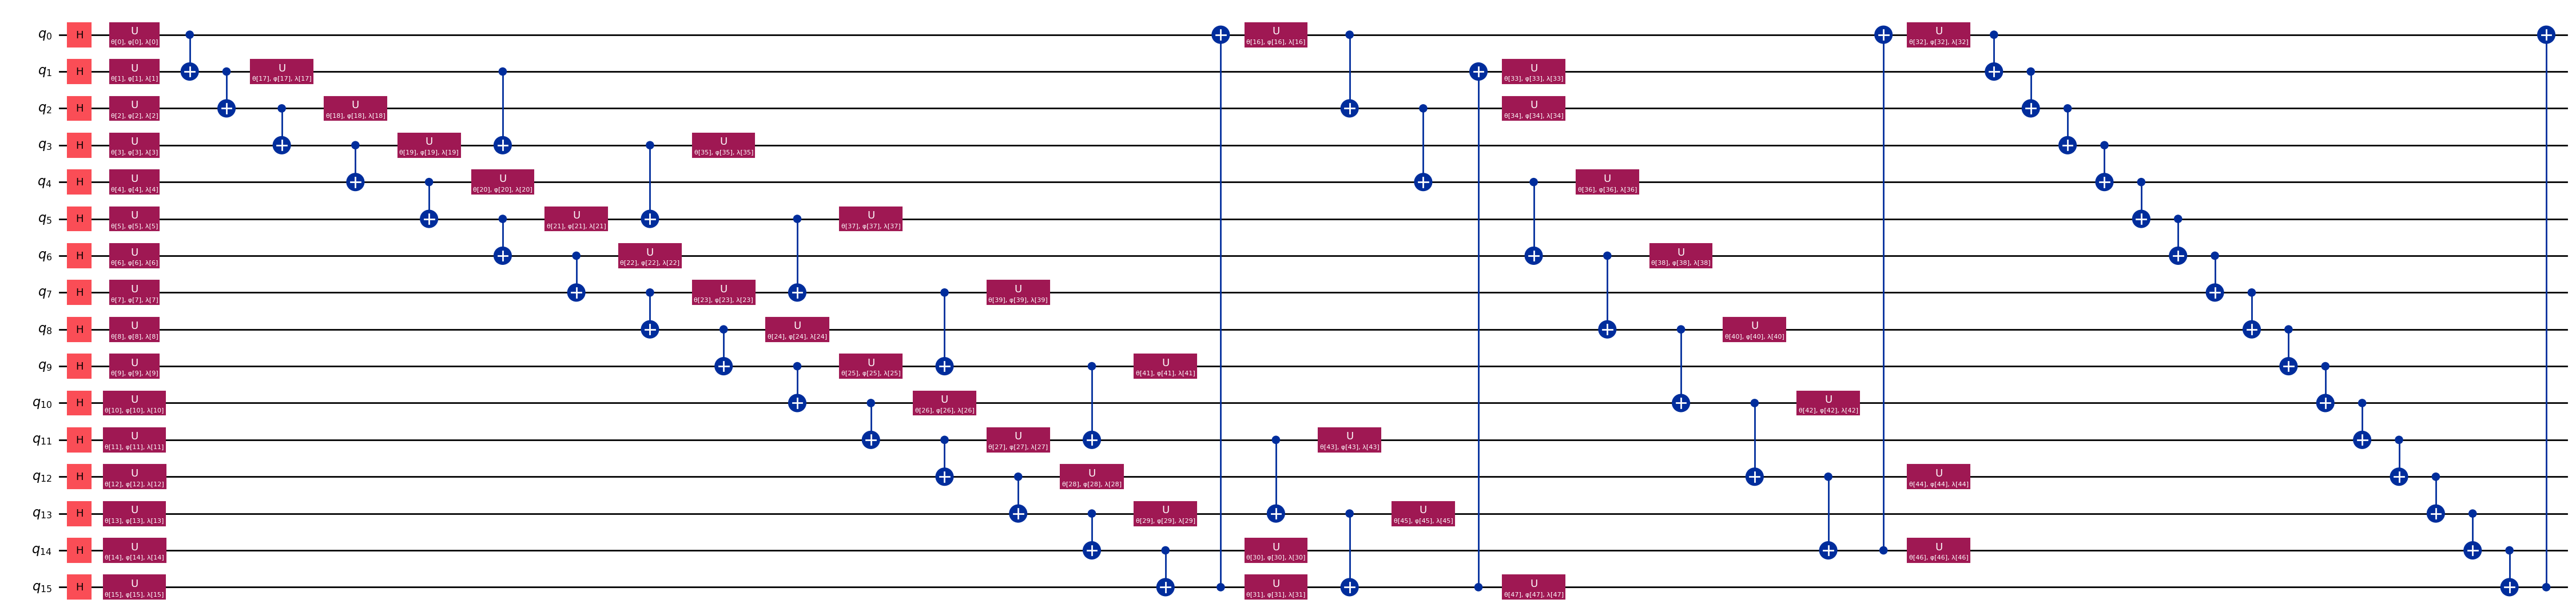

In [2]:
ansatz1.draw('mpl', fold=-1)

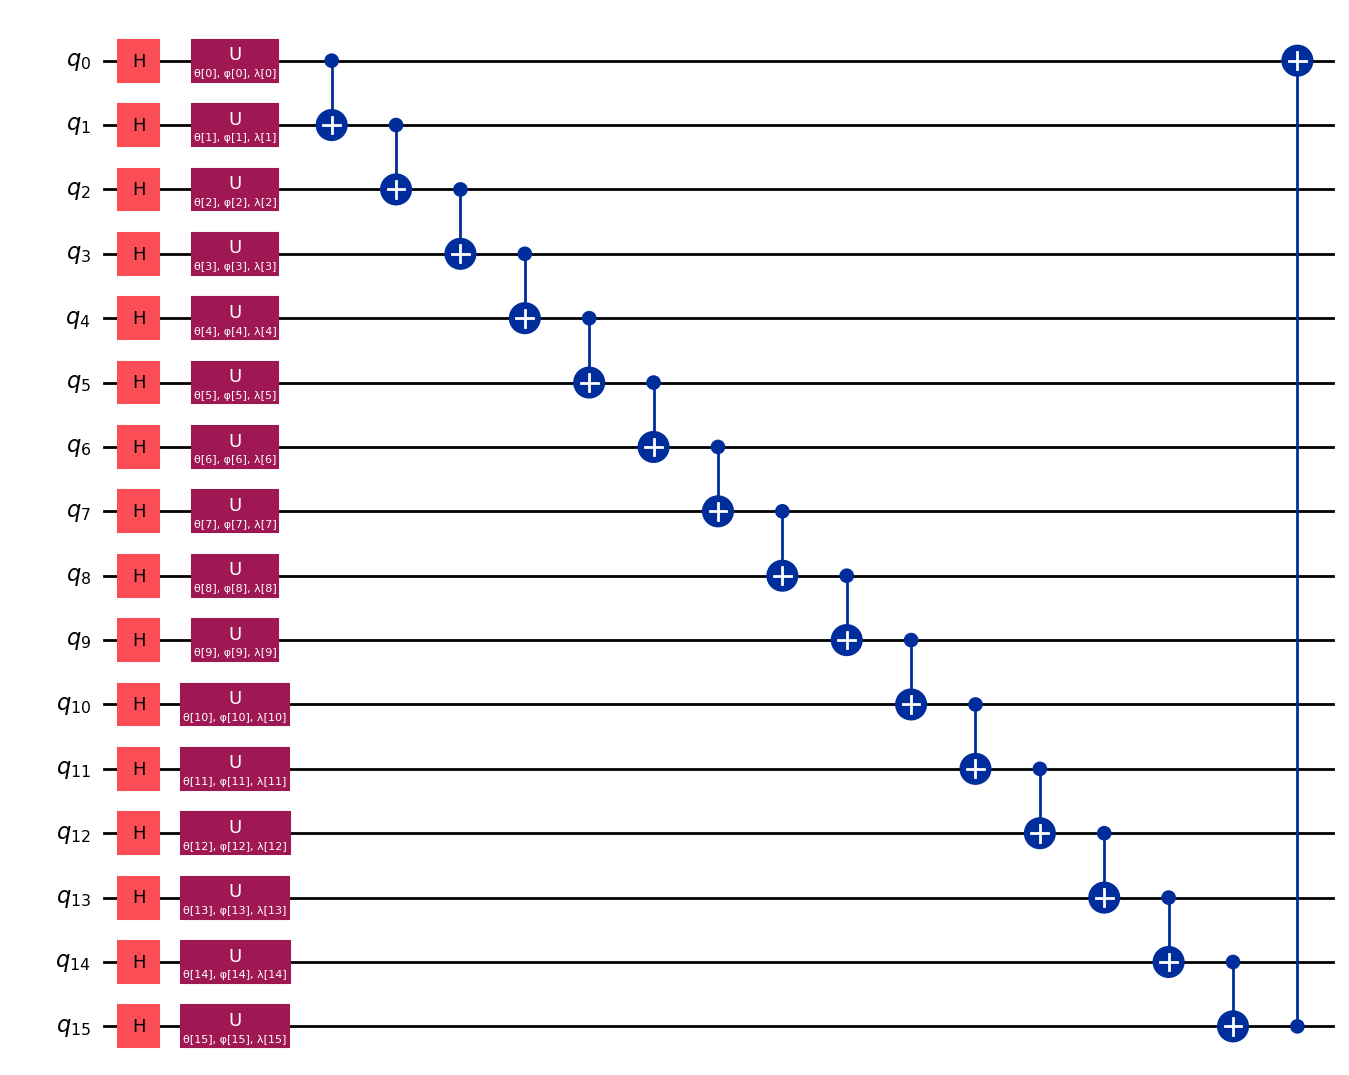

In [3]:
ansatz2, theta, phi, lambda_ = create_improved_ansatz(num_qubits=16, reps=1)
ansatz2.draw('mpl')